**DOCUMENT INFORMATION**
This .ipynb was used to generate the necessary figures depicting Grover's algorithm as well as running time tests for the time it took to run Grover's algorithm and a classical search algorithm.

Importing necessary packages to run code

In [ ]:
!pip install qiskit_aer
!pip install qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 8.7 MB/s eta 0:00:00


In [ ]:
!pip install qiskit_ibm_runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.9/323.9 kB 32.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 15.4 MB/s eta 0:00:00
  Created wheel for ibm-platform-services: filename=ibm_platform_services-0.53.7-py3-none-any.whl size=340285 sha256=af10e68f4fb8a91d4035f848f85839847acce345837cbf8293bf361d81797e20
  Stored in directory: /root/.cache/pip/wheels/8e/54/ad/63e8fdae0e85463bc04a21acf5364cff6def892b95dc40f3ed
  Created wheel for ibm-cloud-sdk

In [ ]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=14088628576e0301fb2046f0252ebdb7d58bcdeb73594ef302058da22fbd27c3
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


This code is duplicated from quantum_grovers.py. This code block is simply used to generate the necessary pictures and diagrams of the oeprators used in Grover's algorithm.

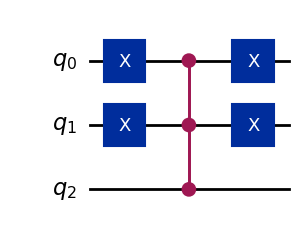

In [ ]:
# Built-in modules
import math
import time
import timeit

# Imports from Qiskit
from qiskit_aer import Aer, AerSimulator
from qiskit_aer.utils import transpile_noise_model
from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.primitives import EstimatorV2
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeTorontoV2

import pylatexenc

# Fake backend from Qiskit
backend = FakeTorontoV2()

# To run on Aer simulator:
#backend = Aer.get_backend('qasm_simulator')
# token = 'd2d452777c1a6e359c82a7b6bb630f0ed071db17f37244e5300bbfbafef2de70e7cc9098d40be5b54ba4e7fb0e25db8d6b8a04d4f6a02f696ad61fc07a4d6584'
# QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
# backend.name


def grover_oracle(marked_states):
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    qc.draw(output="mpl")
    return qc

def grovers(marked_states):

    oracle = grover_oracle(marked_states)

    grover_op = GroverOperator(oracle)

    optimal_num_iterations = math.floor(
        math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
    )

    print(optimal_num_iterations)
    qc = QuantumCircuit(grover_op.num_qubits)
    # Create even superposition of all basis states
    qc.h(range(grover_op.num_qubits))
    # Apply Grover operator the optimal number of times
    qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
    # Measure all qubits
    qc.measure_all()

    return qc
    qc.draw(output="mpl")

# qc = grovers("100")
# qc.draw(output = "mpl")

qc_oracle = grover_oracle("100")
qc_oracle.draw(output = "mpl")



This code block is also duplicated from quantum_grovers.py with some additional functionality to time the processes. Uses the import time to time how long it takes for Grover's algorithm to transpile and run code on a fake backend simulator.

In [ ]:
# Built-in modules
import math
import time
import timeit

# Imports from Qiskit
from qiskit_aer import Aer, AerSimulator
from qiskit_aer.utils import transpile_noise_model
from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.primitives import EstimatorV2
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeTorontoV2

# Build noise model from backend properties
backend = FakeTorontoV2()

# To run on Aer simulator:
#backend = Aer.get_backend('qasm_simulator')
# token = 'd2d452777c1a6e359c82a7b6bb630f0ed071db17f37244e5300bbfbafef2de70e7cc9098d40be5b54ba4e7fb0e25db8d6b8a04d4f6a02f696ad61fc07a4d6584'
# QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
# backend.name

def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

def grovers(marked_states):

    oracle = grover_oracle(marked_states)

    grover_op = GroverOperator(oracle)

    optimal_num_iterations = math.floor(
        math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
    )

    print(optimal_num_iterations)
    qc = QuantumCircuit(grover_op.num_qubits)
    # Create even superposition of all basis states
    qc.h(range(grover_op.num_qubits))
    # Apply Grover operator the optimal number of times
    qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
    # Measure all qubits
    qc.measure_all()

    start_time = time.time()
    circ_ = transpile(qc, backend)
    job = backend.run(circ_)
    end_time = time.time()
    return end_time - start_time

#plot_histogram(counts)
#print(counts)
times_grover = []
states = ["10", "100", "1000", "10000", "100000", "1000000", "10000000", "100000000", "1000000000"]

times_classical = []
def classical(n):
  for i in range(2**n):
    if (i == 2**n - 1):
      print(i)

for i in range(2, 11):
    time_g = grovers([states[i-2]])
    time_c = timeit.timeit(f"classical(i)", globals = globals(), number = 1)
    times_grover.append(time_g)
    times_classical.append(time_c)
    print(times_grover)
    print(times_classical)


1
3
[1.362600564956665]
[0.0001234709999948791]
2
7
[1.362600564956665, 0.22480106353759766]
[0.0001234709999948791, 0.024240263000024243]
3
15
[1.362600564956665, 0.22480106353759766, 0.5269198417663574]
[0.0001234709999948791, 0.024240263000024243, 0.011649404999957369]
4
31
[1.362600564956665, 0.22480106353759766, 0.5269198417663574, 0.8145365715026855]
[0.0001234709999948791, 0.024240263000024243, 0.011649404999957369, 0.013785587000029409]
6
63
[1.362600564956665, 0.22480106353759766, 0.5269198417663574, 0.8145365715026855, 2.031658887863159]
[0.0001234709999948791, 0.024240263000024243, 0.011649404999957369, 0.013785587000029409, 0.007511383999997179]
8
127
[1.362600564956665, 0.22480106353759766, 0.5269198417663574, 0.8145365715026855, 2.031658887863159, 6.317428112030029]
[0.0001234709999948791, 0.024240263000024243, 0.011649404999957369, 0.013785587000029409, 0.007511383999997179, 0.011057438000023012]
12
255
[1.362600564956665, 0.22480106353759766, 0.5269198417663574, 0.81453